In [7]:
from river import drift
from stream_generator import FeatureImportanceChangeGenerator
from drift_runner.drift_runner import DriftDetectionRunner


In [8]:
possible_strategies = [
    'all_features_no_reset',
    'all_features_with_reset',
    'boruta_initial_only',
    'boruta_dynamic',
    'alpha_dynamic']

In [9]:
generator = FeatureImportanceChangeGenerator(n_features=20, n_important_features=5, random_seed=43, importance_change_interval=1)
adwin = drift.ADWIN()
kswin = drift.KSWIN()

Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Epoch 0, Accuracy: 0.00%
Drift detected at index 736, input value: 1
Drift detected at epoch 736 → updating features and resetting model


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Epoch 1000, Accuracy: 78.98%


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Epoch 2000, Accuracy: 82.99%
Drift detected at index 2881, input value: 1
Drift detected at epoch 2881 → updating features and resetting model


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Epoch 3000, Accuracy: 83.22%


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Epoch 4000, Accuracy: 77.49%
Epoch 5000, Accuracy: 73.89%
Drift detected at index 5442, input value: 0
Drift detected at epoch 5442 → updating features and resetting model


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Drift detected at index 5795, input value: 1
Drift detected at epoch 5795 → updating features and resetting model


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Epoch 6000, Accuracy: 71.23%
Epoch 7000, Accuracy: 68.44%


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Feature importance changed at epoch 8000.
Epoch 8000, Accuracy: 66.23%
Drift detected at index 8197, input value: 1
Drift detected at epoch 8197 → updating features and resetting model


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Drift detected at index 8998, input value: 0
Drift detected at epoch 8998 → updating features and resetting model


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Epoch 9000, Accuracy: 68.15%


           Precision   Recall   F1       Support  
                                                  
       0      70.89%   59.68%   64.80%      4888  
       1      65.88%   76.06%   70.61%      5004  
                                                  
   Macro      68.38%   67.87%   67.70%            
   Micro      67.96%   67.96%   67.96%            
Weighted      68.36%   67.96%   67.74%            

                 67.96% accuracy                  
Plot saved to ./plots/boruta/161_seed/2000_window/boruta_dynamic.png


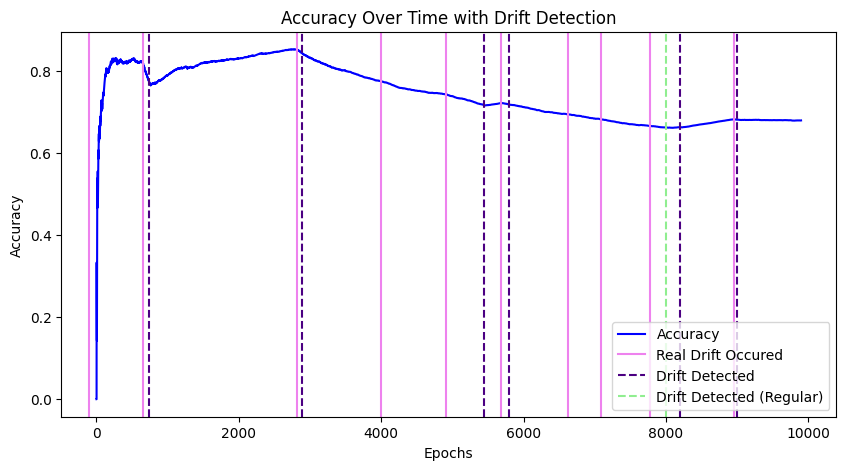

In [10]:
strategy = 'boruta_dynamic'
n_history = 2000
seed = 161
feature_selector = 'boruta'

generator = FeatureImportanceChangeGenerator(20, 5, importance_change_interval=10, random_seed=seed)

if strategy in ['boruta_initial_only', 'boruta_dynamic', 'alpha_dynamic']:
    plot_path = f'./plots/{feature_selector}/{seed}_seed/{n_history}_window/{strategy}.png'
else:
    plot_path = f'./plots/{feature_selector}/{seed}_seed/{strategy}.png'



runner = DriftDetectionRunner(generator, adwin, feature_selector, n_history=2000, plot_path=plot_path)
runner.run(mode=strategy)

In [11]:
generator.random_seed

161